# Visualization of Lunar Terrain Isolines Using Dual Marching Squares
## Brian J. Stafford (brianjs4@illinois.edu, brianjstafford@gmail.com)
## CS519 - Final Project
## December 2020

## Introduction
    
In this project, I present several different visualizations of the lunar terrain and implement contours using dual marching squares in order to compare and contrast the results with contours produced by marching squares.
 
I will be working with **PyVista** throughout, a Python interface for the **Visualization Toolkit (VTK)**. For reference, see:

- https://docs.pyvista.org/
- https://vtk.org/

The data used for this project are color and Digital Elevation Model (DEM) images obtained by NASA using the Lunar Reconnaissance Orbiter camera and laser altimeter instrument teams (see https://svs.gsfc.nasa.gov/4720). For further information on the source data see the accompanying document, "VisualizationOfLunarTerrainIsolinesUsingDualMarchingSquares.docx" 

Using this data, I will do the following:

- Display a planar color image of the moon, without height information
- Display a planar image of the moon using color and a warped mesh from the DEM 
- Display primal contours rendered on the planar image using a built-in PyVista method
- Implement dual marching squares side-by-side with the marching squares algorithm from CS519 MP1, and compare the differences in MP1's sample visualization
- Use my dual marching squares implementation to display contours on a subset of the planar moon image, and compare these contours to those generated by the built-in PyVista method

To run this Jupyter Notebook in your own environment, make sure you have installed the necessary dependencies (see the imports below).

## Part 1: Color Image

In this Part, I load the color image of the lunar terrain and display it as a planar image on the unwarped DEM of the moon.

In [1]:
#Import necessary packages
%matplotlib inline
from pyvista import set_plot_theme
set_plot_theme('document')

import pyvista as pv
import math
import numpy as np
import pylab as plt
import pyvistaqt as pvqt

In [2]:
#Load the lunar color texture
lunar_color = pv.read_texture("lroc_color_poles_8k.png")

#Load the DEM to use as our mesh - but do not warp by scalar yet
lunar_dem_16 = pv.read("lunar_dem_16.tif")

#Add texture coordinates to the mesh
lunar_dem_16.texture_map_to_plane(inplace = True)

#Display data for the 16-bit DEM
lunar_dem_16

UniformGrid (0x16039fd70)
  N Cells:	16580161
  N Points:	16588800
  X Bounds:	0.000e+00, 1.463e+03
  Y Bounds:	0.000e+00, 7.313e+02
  Z Bounds:	0.000e+00, 0.000e+00
  Dimensions:	5760, 2880, 1
  Spacing:	2.540e-01, 2.540e-01, 2.540e-01
  N Arrays:	2

The following is a static 3-D view of the lunar planar color image.

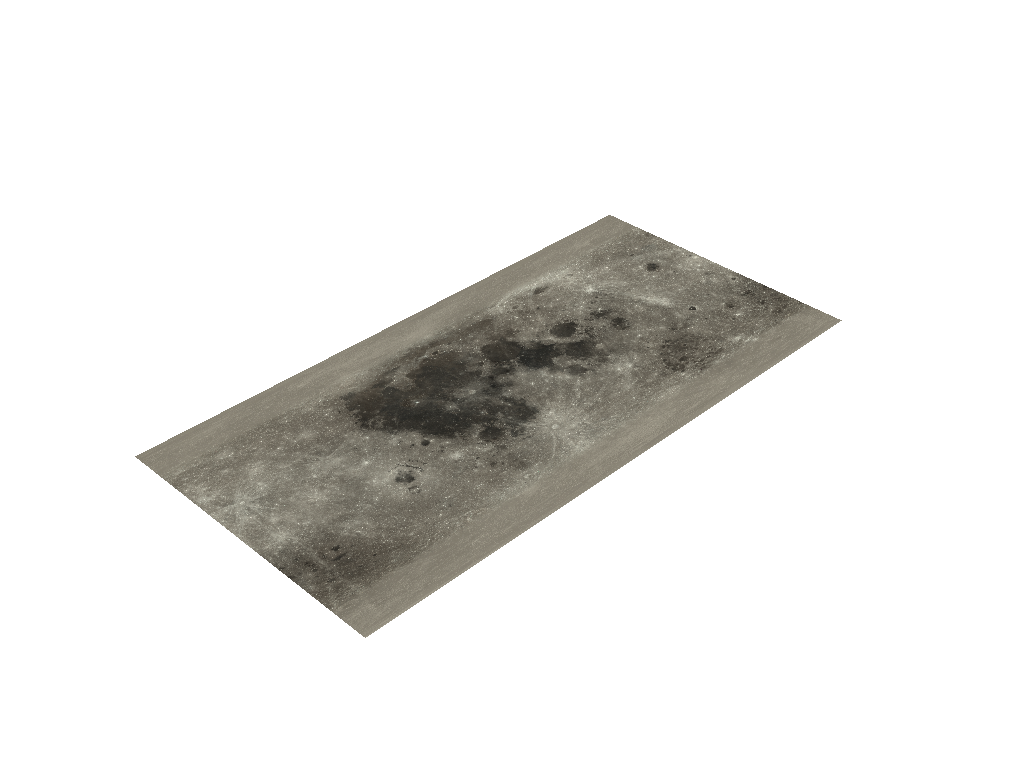

In [3]:
pv.plot(lunar_dem_16, texture = lunar_color)

Running the following cell will spawn an external viewer that contains an interactive 3-D view of the above plot. 
It is commented out because it can cause performance issues. Uncomment to launch the external viewer, and use your 
mouse and control/command buttons to navigate and explore the lunar color image. You may need to force quit it if it ends up using too many resources or if it interferes with running additional cells in this notebook.

In [4]:
'''
plotter = pvqt.BackgroundPlotter()
plotter.add_mesh(lunar_dem_16, texture = lunar_color)
'''

'\nplotter = pvqt.BackgroundPlotter()\nplotter.add_mesh(lunar_dem_16, texture = lunar_color)\n'

## Part 2: Terrain Mesh

In this Part, I warp the lunar terrain mesh using the DEM information and display it.


In [5]:
#Warp the mesh using the height data
lunar_terrain_16 = lunar_dem_16.warp_by_scalar()

The following is a static 3-D view of the lunar terrain mesh.

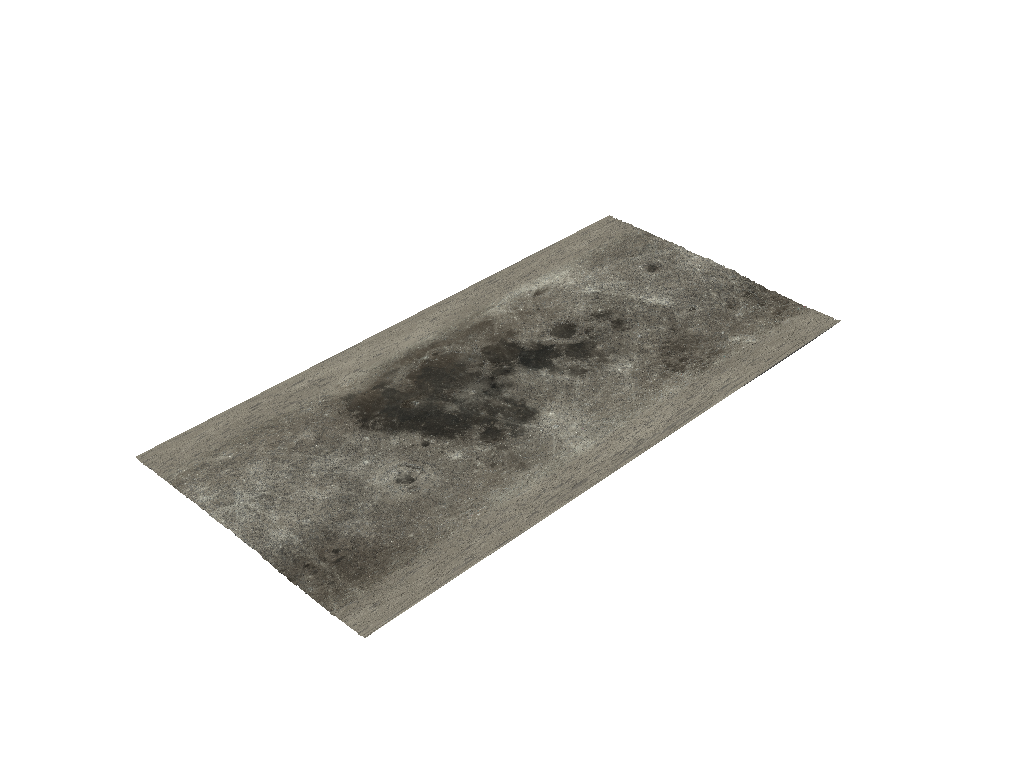

In [6]:
pv.plot(lunar_terrain_16, texture = lunar_color)

Running the following cell will spawn an external viewer that contains an interactive 3-D view of the above plot. 
It is commented out because it can cause performance issues. Uncomment to launch the external viewer, and use your 
mouse and control/command buttons to navigate and explore the lunar color image. You may need to force quit it if it ends up using too many resources or if it interferes with running additional cells in this notebook.

In [7]:
'''
plotter = pvqt.BackgroundPlotter()
plotter.add_mesh(lunar_terrain_16, texture = lunar_color)
'''

'\nplotter = pvqt.BackgroundPlotter()\nplotter.add_mesh(lunar_terrain_16, texture = lunar_color)\n'

## Part 3: PyVista Contours

In this Part, I create primal contours (using 10 isosurfaces) for the lunar terrain using the built-in PyVista function.

In [8]:
#Create the contours using 10 isosurfaces
contours_16 = lunar_terrain_16.contour(isosurfaces = 10)

The following is static 3-D view of the lunar terrain with these contours displayed.

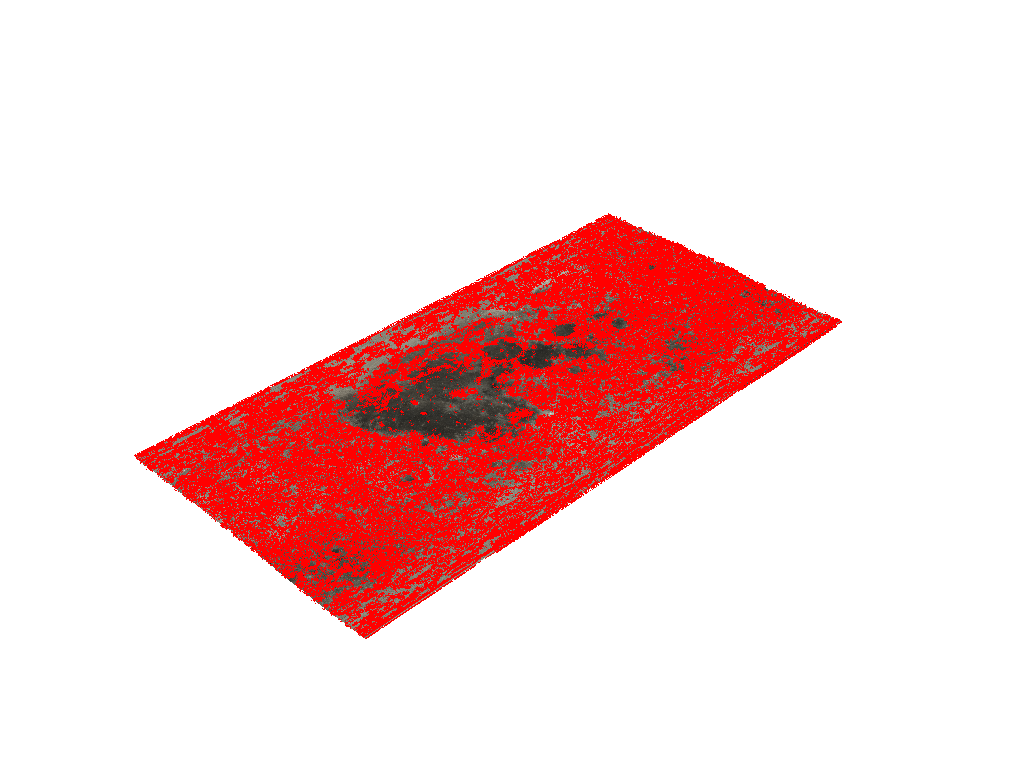

In [9]:
plotter = pv.Plotter()
plotter.add_mesh(lunar_terrain_16, texture = lunar_color)
plotter.add_mesh(contours_16, color="red", line_width=5)
plotter.show()

Running the following cell will spawn an external viewer that contains an interactive 3-D view of the above plot. 
It is commented out because it can cause performance issues. Uncomment to launch the external viewer, and use your 
mouse and control/command buttons to navigate and explore the lunar color image. You may need to force quit it if it ends up using too many resources or if it interferes with running additional cells in this notebook.

In [10]:
'''
plotter = pvqt.BackgroundPlotter()
plotter.add_mesh(lunar_terrain_16, texture = lunar_color)
plotter.add_mesh(contours_16, color="red", line_width=5)
'''

'\nplotter = pvqt.BackgroundPlotter()\nplotter.add_mesh(lunar_terrain_16, texture = lunar_color)\nplotter.add_mesh(contours_16, color="red", line_width=5)\n'

## Part 4: Implement Dual Marching Squares

In this Part I pull in the marching squares code implemented in CS519 MP1 and implement dual marching squares for comparison.

In [11]:
import random

#Logging to track errors
import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='mylog.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
#logger.setLevel(logging.ERROR) #enable to see logging output

In [12]:
from matplotlib.widgets import Button
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib notebook

In [13]:
#We will use a 2-D Gaussian function to generate the grid that we will apply marching squares 
#and dual marching squares to.
def gauss_2d(mu, sigma, size=10):
  x, y = np.meshgrid(np.linspace(-1,1,size), np.linspace(-1,1,size))
  d    = np.sqrt(x*x+y*y)
  g    = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
  return g

I have modified the March class from CS519 MP1 to allow the user to view the Dual Marching Squares (Dual Contours) implementation. I also fixed the inconsistent grid between the No Contours and Primal/Dual Contours views that existed in CS519 MP1.

In [14]:
#The following code constructs the March class which uses the related functions to plot an interactive visualization. 
#This class uses the matplotlib library to generate the grid, contour lines, and colormaps.
class March(object):
    def __init__(self,res=32,thres=0.5,size=320):

        #Initialize variables
        self.res      = res                      #Number of grid cells per axis
        self.thres    = thres                    #Threshold for binarization
        self.size     = size                     #Size of image (in pixels)
        self.contours = 0                        #Whether we're showing contours (0 = off,  1 = normal, 2 = interpolated)
        self.cmap     = self.colorMapGrayscale() #Default grayscale color map
        self.cmapi    = 0                        #Index of color map (0 = gray, 1 = plasma, 2 = custom)

        #Hardcode some cells to start with to test all cases
        self.cells    = gauss_2d(0.5,0.4,self.res)

        #Compute other useful variables from grid size
        self.step     = self.size // self.res #Spacing between grid lines (in pixels)

        #Set up axes
        self.fig, self.axes = plt.subplots()
        self.axes.set_aspect('equal')
        plt.subplots_adjust(bottom=0.2)

        #Set up buttons
        self.btog = Button(plt.axes([0.61, 0.05, 0.2, 0.075]), 'No Contours')
        self.btog.on_clicked(self.toggle_contours)
        self.bmap = Button(plt.axes([0.41, 0.05, 0.2, 0.075]), 'Grayscale')
        self.bmap.on_clicked(self.toggle_colormap)

        #Perform initial drawing
        self.redraw()

    def show(self):
        plt.show()

    def update(self):
        self.fig.canvas.draw()

    def toggle_contours(self,event):
        #Toggle whether we draw contours or not
        self.contours = (self.contours + 1) % 3
        self.redraw()

    def toggle_colormap(self,event):
        self.cmapi = (self.cmapi+1)%2
        if self.cmapi == 0:
          self.cmap = self.colorMapGrayscale()
          self.bmap.label.set_text("Grayscale")
        elif self.cmapi == 1:
          self.cmap = colorMapPlasma()
          self.bmap.label.set_text("Plasma")
        self.redraw()

    def redraw(self):
        # Regenerate a blank white canvas without axis lines or tick marks
        self.axes.clear()
        self.axes.set_yticks([])
        self.axes.set_xticks([])
        self.axes.set_yticklabels([])
        self.axes.set_xticklabels([])

        #Invert y axis to match up with array ordering
        self.axes.invert_yaxis()

        #Draw the image from our img matrix
        self.drawImage()
        if self.contours == 0:
            for i in range(self.res): #Draw contour grid 
                self.axes.plot([0,self.size-1], [self.step*(i+0.5),self.step*(i+0.5)], color='gray', linestyle='-', linewidth=1)
                self.axes.plot([self.step*(i+0.5),self.step*(i+0.5)], [0,self.size-1], color='gray', linestyle='-', linewidth=1)
            self.btog.label.set_text('No Contours')
        else:  # Draw contours and contour grid
          for i in range(self.res): #Draw contour grid
            self.axes.plot([0,self.size-1], [self.step*(i+0.5),self.step*(i+0.5)], color='gray', linestyle='-', linewidth=1)
            self.axes.plot([self.step*(i+0.5),self.step*(i+0.5)], [0,self.size-1], color='gray', linestyle='-', linewidth=1)
          if self.contours == 1:
            self.btog.label.set_text('Primal Contours')
            self.drawInterpolatedContours()
          elif self.contours == 2:
            self.btog.label.set_text('Dual Contours')
            self.drawDualContours()

        #Update the underlying plot
        self.update()

    def colorMapGrayscale(self):
        cdict = {'red':   [[0, 0, 0],
                           [1, 1, 1]],
                 'green': [[0, 0, 0],
                           [1, 1, 1]],
                 'blue':  [[0, 0, 0],
                           [1, 1, 1]]}
        return cdict

    def drawImage(self):
        newcmp = LinearSegmentedColormap('testCmap', segmentdata=self.cmap, N=256)
        self.axes.imshow(gauss_2d(0.5,0.4,self.size),cmap=newcmp)

    def drawInterpolatedContours(self):
        logger.error("drawInterpolatedContours")
        segments = getContourSegments(self.thres,self.cells)
        logger.error(str(segments[0][0][0]))
        logger.error(str(segments[0][1][0]))
        logger.error(str(segments[0][0][1]))
        logger.error(str(segments[0][1][1]))
        for s in segments:
            x1 = self.step*(0.5+s[0][0])
            x2 = self.step*(0.5+s[1][0])
            y1 = self.step*(0.5+s[0][1])
            y2 = self.step*(0.5+s[1][1])
            self.axes.plot([x1,x2], [y1,y2], color='green', linestyle='-', linewidth=1)
        
    def drawDualContours(self):
        logger.error("drawDualContours")
        segments = getDualContourSegments(self.thres,self.cells)
        logger.error(str(segments[0][0][0]))
        logger.error(str(segments[0][1][0]))
        logger.error(str(segments[0][0][1]))
        logger.error(str(segments[0][1][1]))
        for s in segments:
            x1 = self.step*(0.5+s[0][0])
            x2 = self.step*(0.5+s[1][0])
            y1 = self.step*(0.5+s[0][1])
            y2 = self.step*(0.5+s[1][1])
            self.axes.plot([x1,x2], [y1,y2], color='green', linestyle='-', linewidth=1)

In [15]:
def getContourCase(top,left,thres,cells):
    width = cells.shape[0]
    height = cells.shape[1]
    if top < 0 or top >= (height-1) or left < 0 or left >= (width-1):
        return 0
    code = 0
    if cells[top][left] >= thres:
        code += 8
    if cells[top][left+1] >= thres:
        code += 4
    if cells[top+1][left+1] >= thres:
        code += 2
    if cells[top+1][left] >= thres:
        code += 1
    
    return code  

In [16]:
def disambiguateSaddle(top,left,thres,cells):
    width = cells.shape[0]
    height = cells.shape[1]
    if top < 0 or top >= (height-1) or left < 0 or left >= (width-1):
        return 0
    avg = (cells[top][left] + cells[top][left+1] + cells[top+1][left+1] + cells[top+1][left])/4
    if (avg >= thres):
        return True
    else:
        return False

In [17]:
def interpolate(v1,v2,t):
    diff = v2 - v1
    if diff == 0: 
        param = 0
    else:
        param = (t - v1) / diff
    return param

In [18]:
def getCellSegments(top,left,thres,cells):
    width = cells.shape[0]
    height = cells.shape[1]
    if top < 0 or top >= (height-1) or left < 0 or left >= (width-1):
        return []

    case = getContourCase(top,left,thres,cells)
    if case == 0 or case == 15:
        return []

    segments = []
    q1 = (left + interpolate(cells[top][left], cells[top][left+1], thres), top)
    q2 = (left+1, top + interpolate(cells[top][left+1], cells[top+1][left+1], thres))
    q3 = (left + interpolate(cells[top+1][left], cells[top+1][left+1], thres), top+1)
    q4 = (left, top + interpolate(cells[top][left], cells[top+1][left], thres))

    code = getContourCase(top, left, thres, cells)
    highCenter = disambiguateSaddle(top, left, thres, cells)

    if code == 0b1010:
        if highCenter:
            segments.append([q1,q2])
            segments.append([q4,q3])
        else:
            segments.append([q4,q1])
            segments.append([q3,q2])
    elif code == 0b0101:
        if highCenter:
            segments.append([q4,q1])
            segments.append([q3,q2])
        else:
            segments.append([q1,q2])
            segments.append([q4,q3])
    elif code == 0b1110 or code == 0b0001:
        segments.append([q3,q4])
    elif code == 0b1101 or code == 0b0010:
        segments.append([q2,q3])
    elif code == 0b1011 or code == 0b0100:
        segments.append([q1,q2])
    elif code == 0b0111 or code == 0b1000:
        segments.append([q1,q4])
    elif code == 0b1100 or code == 0b0011:
        segments.append([q2,q4])
    elif code == 0b1001 or code == 0b0110:
        segments.append([q1,q3])

    return segments

In [19]:
#This function returns the midpoint of two vertices
def getMidpoint(v1, v2):
    return ((v1[0]+v2[0])/2, (v1[1]+v2[1])/2)
    
#This function finds the dual vertices inside the cells
def getCellVertices(top,left,thres,cells):
    try:
        width = cells.shape[0]
        height = cells.shape[1]
        if top < 0 or top >= (height-1) or left < 0 or left >= (width-1):
            return []

        code = getContourCase(top,left,thres,cells)
        if code == 0 or code == 15:
            return []

        vertices = {}
        q1 = (left + interpolate(cells[top][left], cells[top][left+1], thres), top)
        q2 = (left + 1, top + interpolate(cells[top][left+1], cells[top+1][left+1], thres))
        q3 = (left + interpolate(cells[top+1][left], cells[top+1][left+1], thres), top+1)
        q4 = (left, top + interpolate(cells[top][left], cells[top+1][left], thres))

        #Store the cell intersections for use in edge row/columns
        vertices["q1"] = q1
        vertices["q2"] = q2
        vertices["q3"] = q3
        vertices["q4"] = q4
        
        #Initialize v2 to a dummy value in case it doesn't get set
        vertices["v2"] = (0,0)
        
        if code == 0b0100 or code == 0b1011:
            vertices["v1"] = getMidpoint(q1,q2)
        elif code == 0b0110 or code == 0b1001:
            vertices["v1"] = getMidpoint(q1,q3)
        elif code == 0b1000 or code == 0b0111:
            vertices["v1"] = getMidpoint(q1,q4)
        elif code == 0b1110 or code == 0b0001:
            vertices["v1"] = getMidpoint(q3,q4)
        elif code == 0b1100 or code == 0b0011:
            vertices["v1"] = getMidpoint(q2,q4)            
        elif code == 0b0010 or code == 0b1101:
            vertices["v1"] = getMidpoint(q2,q3)
        elif code == 0b1010: #This case generates 2 vertices
            vertices["v1"] = getMidpoint(q1,q4)
            vertices["v2"] = getMidpoint(q2,q3)
        elif code == 0b0101: #This case generates 2 vertices 
            vertices["v1"] = getMidpoint(q1,q2)
            vertices["v2"] = getMidpoint(q3,q4)

    except Exception as e: 
        #print("getCellVertices exception:" + str(e))
        logger.error("exception:" + str(e))
    return vertices

In [20]:
def getContourSegments(thres,cells):
    num_rows = cells.shape[0]
    num_cols = cells.shape[1]
    all_segments = []
    for y in range(0, num_rows):
        for x in range(0, num_cols):
            segments = getCellSegments(y, x, thres,cells)
            if (len(segments) > 0):
                all_segments = all_segments + segments
    return all_segments

In [21]:
#Gets a dictionary of dual contour vertices, indexed by the (x,y) cell identifier
def getDualContourVerticesDict(thres,cells):
    num_rows = cells.shape[0] - 1 
    num_cols = cells.shape[1] - 1
    all_vertices = {}
    try:
        for y in range(0, num_rows):
            for x in range(0, num_cols):
                #logger.error("(" + str(x) + "," + str(y) + ")")
                vertices = getCellVertices(y, x, thres, cells)
                if (len(vertices) > 0):
                    all_vertices[(x,y)] = vertices
    except Exception as e: 
        #print("getDualContourVerticesDict exception:" + str(e))
        logger.error("exception:" + str(e))
    return all_vertices

def getAboveSegment(all_segments, vertex, interp_vertex, above, two_vertices_above, above_v1, above_v2):
    if (above != None):
        if two_vertices_above:
            all_segments.append([vertex, above_v2])
        else:
            all_segments.append([vertex, above_v1])                                
    else:
        all_segments.append([vertex, interp_vertex])                            

def getLeftSegment(all_segments, vertex, interp_vertex, left, left_code, left_v1, left_v2):
    if (left != None):
        if left_code == 0b1010:
            all_segments.append([vertex, left_v2])
        else:
            all_segments.append([vertex, left_v1])                                
    else:
        all_segments.append([vertex, interp_vertex])    
                            
def getDualContourSegments(thres,cells):
    vertices = getDualContourVerticesDict(thres,cells)
    num_rows = cells.shape[0] - 1
    num_cols = cells.shape[1] - 1
    all_segments = []
    try:
        for y in range(0, num_rows):
            for x in range(0, num_cols):
                if ((x,y) in vertices):
                    above = left = None
                    above_code = left_code = 0
                    above_v1 = above_v2 = None
                    left_v1 = left_v2 = None
                    cell_vertices = vertices[(x,y)]
                    
                    if (x,y-1) in vertices:
                        above = vertices[(x,y-1)]
                        above_v1 = above["v1"]
                        above_v2 = above["v2"]
                        above_code = getContourCase(y-1,x,thres,cells)
                    if (x-1,y) in vertices:
                        left = vertices[(x-1,y)]
                        left_v1 = left["v1"]
                        left_v2 = left["v2"]
                        left_code = getContourCase(y,x-1,thres,cells)
                                        
                    code = getContourCase(y,x,thres,cells)
                    
                    v1 = cell_vertices["v1"]
                    v2 = cell_vertices["v2"]                

                    two_vertices_above = above_code == 0b1010 or above_code == 0b0101
                    
                    if code == 0b1000 or code == 0b0111:
                        getAboveSegment(all_segments, v1, cell_vertices["q1"], above, two_vertices_above, above_v1, above_v2)
                        getLeftSegment(all_segments, v1, cell_vertices["q4"], left, left_code, left_v1, left_v2)                        
                    elif code == 0b0100 or code == 0b1011:
                        getAboveSegment(all_segments, v1, cell_vertices["q1"], above, two_vertices_above, above_v1, above_v2) 
                        if (x == num_cols-1):
                            all_segments.append([v1, cell_vertices["q2"]])
                    elif code == 0b1100 or code == 0b0011:
                        getLeftSegment(all_segments, v1, cell_vertices["q4"], left, left_code, left_v1, left_v2)                        
                        if (x == num_cols-1):
                            all_segments.append([v1, cell_vertices["q2"]])                            
                    elif code == 0b0010 or code == 0b1101:
                        if (x == num_cols-1):
                            all_segments.append([v1, cell_vertices["q2"]])  
                        if (y == num_rows-1):
                            all_segments.append([v1, cell_vertices["q3"]])                              
                    elif code == 0b0110 or code == 0b1001:
                        getAboveSegment(all_segments, v1, cell_vertices["q1"], above, two_vertices_above, above_v1, above_v2)
                        if (y == num_rows-1):
                            all_segments.append([v1, cell_vertices["q3"]])                                                          
                    elif code == 0b1110 or code == 0b0001:
                        getLeftSegment(all_segments, v1, cell_vertices["q4"], left, left_code, left_v1, left_v2)                        
                        if (y == num_rows-1):
                            all_segments.append([v1, cell_vertices["q3"]])                              
                    elif code == 0b1010:
                        #Connect top vertex
                        getAboveSegment(all_segments, v1, cell_vertices["q1"], above, two_vertices_above, above_v1, above_v2)
                        getLeftSegment(all_segments, v1, cell_vertices["q4"], left, left_code, left_v1, left_v2)                        

                        #Connect bottom vertex
                        if (x == num_cols-1):
                            all_segments.append([v2, cell_vertices["q2"]])  
                        if (y == num_rows-1):
                            all_segments.append([v2, cell_vertices["q3"]])                                                                                      
                    elif code == 0b0101:
                        #Connect top vertex
                        getAboveSegment(all_segments, v1, cell_vertices["q1"], above, two_vertices_above, above_v1, above_v2)
                        if (x == num_cols-1):
                            all_segments.append([v1, cell_vertices["q2"]])  

                        #Connect bottom vertex
                        getLeftSegment(all_segments, v2, cell_vertices["q4"], left, left_code, left_v1, left_v2)                        
                        if (y == num_rows-1):
                            all_segments.append([v2, cell_vertices["q3"]])             
    except Exception as e: 
        #print("exception: " + str(e) + " code: " + str(code) + " left code: " + str(left_code) + " x: " + str(x) + " y: " + str(y))
        logger.error("exception:" + str(e))
    return all_segments

In [22]:
def colorMapPlasma():
    cdict = {'red':   [(0.0,        47/255,      47/255),
                   (0.142857142857142,    98/255,   98/255),
                   (0.285714285714285,    146/255, 146/255),
                   (0.428571428571428,    186/255, 186/255),
                   (0.571428571428571,    216/255, 216/255),
                   (0.714285714285714,    238/255, 238/255),
                   (0.857142857142857,    246/255, 246/255),
                   (1,              228/255, 228/255)],

        'green': [(0.0,             0.0,       0/255),
                   (0.142857142857142,    0/255,     0/255),
                   (0.285714285714285,    0/255,     0/255),
                   (0.428571428571428,    47/255, 47/255),
                   (0.571428571428571,    91/255, 91/255),
                   (0.714285714285714,    137/255, 137/255),
                   (0.857142857142857,    189/255, 189/255),
                   (1,              250/255, 250/255)],
                
        'blue':  [(0.0,             135/255,       135/255),
                   (0.142857142857142,    164/255,   164/255),
                   (0.285714285714285,    166/255,   166/255),
                   (0.428571428571428,    138/255, 138/255),
                   (0.571428571428571,    105/255, 105/255),
                   (0.714285714285714,    73/255, 73/255),
                   (0.857142857142857,    39/255, 39/255),
                   (1,              21/255, 21/255)]}
    return cdict

dict = colorMapPlasma()

Here we run the March code, which allows you to toggle between Grayscale and the Plasma colormap, as well as No Contours, Primal Contours, and Dual Contours.

You will notice that Dual Contours provides a better approximation to circles than Primal Contours. This is expected, as the CS 519 lecture notes indicate that there is empirical evidence that Dual Marching Squares generates better approximations to curved isolines.

Dual Marching Squares also has a reputation for being better at reproducing sharp features. You will notice in the plot that, with a relatively coarse grid, Dual Marching Squares has sharp points in places.

These features of Dual Marching Squares make them an attractive option for contouring the lunar terrain.

<IPython.core.display.Javascript object>


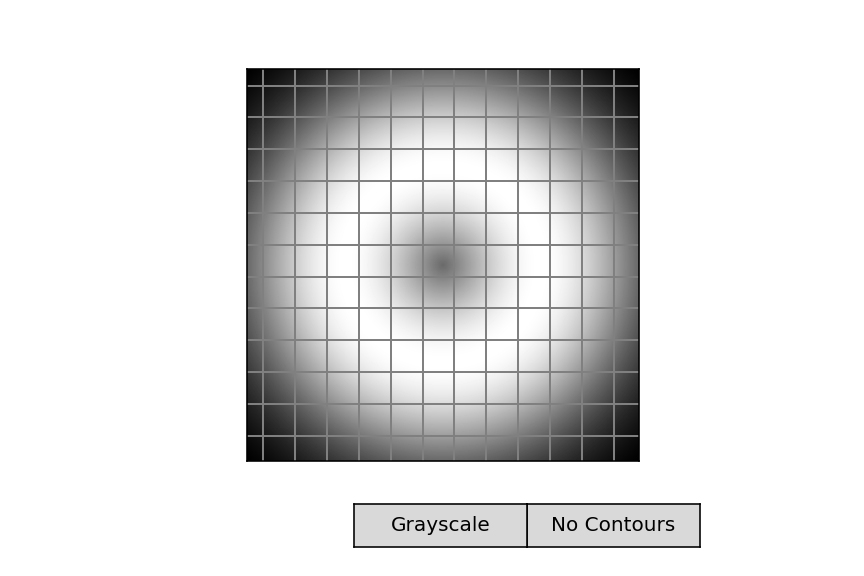

In [23]:
March(res=12,thres=0.9).show()

## Part 5: Comparison of Contour Methods on the Lunar Terrain

Next, we take a small subset of the lunar DEM (small to improve performance) and create contours at a single isosurface (elevation of 0) with our Dual Marching Squares algorithm.

In [24]:
#Extract a small subset of the lunar terrain
subset_16 = lunar_dem_16.extract_subset((1349, 1445, 1698, 1794, 0, 0), (1,1,1))

#Add texture coordinates
subset_16.texture_map_to_plane(inplace = True)

#Load a subset of the lunar color image
lunar_color_subset = pv.read_texture("lunar_color_subset.png")

#Create contours at elevation = 0 using my Dual Marching Squares implementation
subset_16_height_array = subset_16.active_scalars.reshape(subset_16.dimensions[0], subset_16.dimensions[1])   
subset_16_segments = getDualContourSegments(0, subset_16_height_array)

Below we display a static 3-D plot of the contours generated by Dual Marching Squares on the lunar terrain. Note there appears to be a bug in one of the libraries where the lunar color image sometimes does not appear. Often, re-running the previous cell and this cell will fix the issue (generating the texture coordinates in both places is also a workaround that seems to minimize this issue).

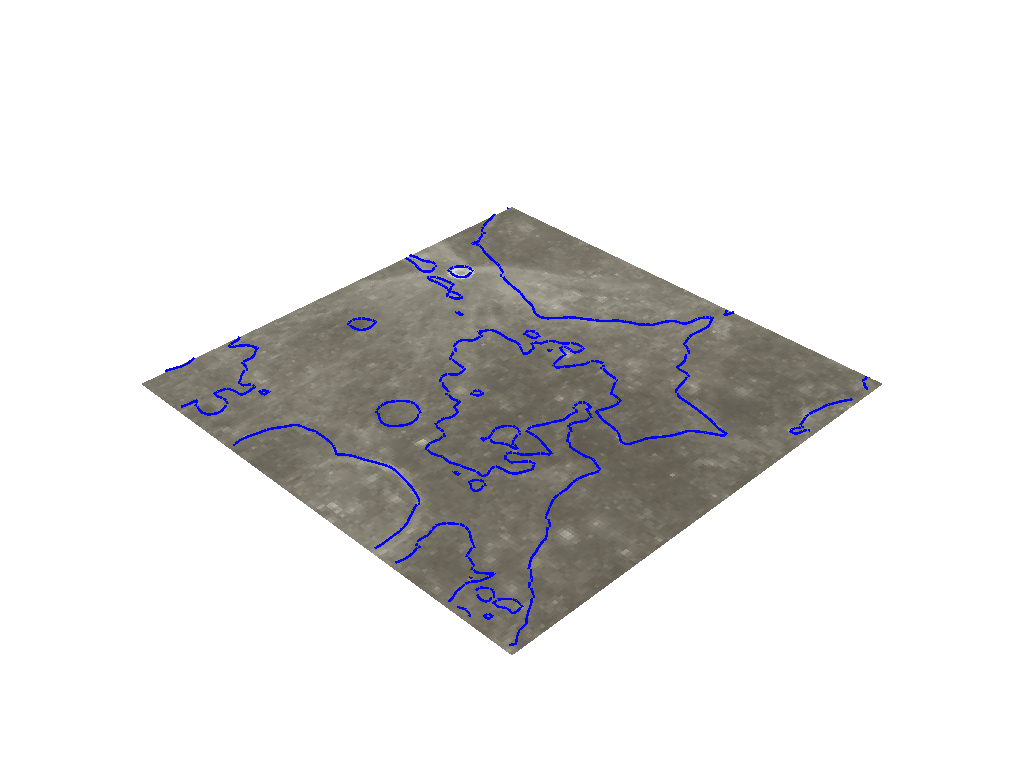

In [25]:
dim_x = subset_16.dimensions[0]
dim_y = subset_16.dimensions[1]
base_x = np.min(subset_16.x)
base_y = np.min(subset_16.y)
width_x = np.max(subset_16.x) - np.min(subset_16.x)
width_y = np.max(subset_16.y) - np.min(subset_16.y)

def plotDualContours(plotter, segments):
    for segment in segments:
        x1 = segment[0][0]/dim_x * width_x + base_x
        x2 = segment[1][0]/dim_x * width_x + base_x
        y1 = segment[0][1]/dim_y * width_y + base_y
        y2 = segment[1][1]/dim_y * width_y + base_y
        line = pv.Line(pointa = (x1, y1, 0), pointb = (x2, y2, 0))
        plotter.add_mesh(line, color="blue", line_width=5)
        
#Add texture coordinates
subset_16.texture_map_to_plane(inplace = True)

plotter = pv.Plotter()
plotter.add_mesh(subset_16, texture = lunar_color_subset)
plotDualContours(plotter, subset_16_segments)
plotter.show()

Running the following cell will spawn an external viewer that contains an interactive 3-D view of the above plot. 
It is commented out because it can cause performance issues. Uncomment to launch the external viewer, and use your 
mouse and control/command buttons to navigate and explore the lunar color image. You may need to force quit it if it ends up using too many resources or if it interferes with running additional cells in this notebook.

In [26]:
'''
plotter = pvqt.BackgroundPlotter()
plotter.add_mesh(subset_16, texture = lunar_color_subset)
plotDualContours(plotter, subset_16_segments)
plotter.show()
'''

'\nplotter = pvqt.BackgroundPlotter()\nplotter.add_mesh(subset_16, texture = lunar_color_subset)\nplotDualContours(plotter, subset_16_segments)\nplotter.show()\n'

For comparison purposes, we once again generate built-in PyVista contours on the same subset of the lunar terrain mesh.

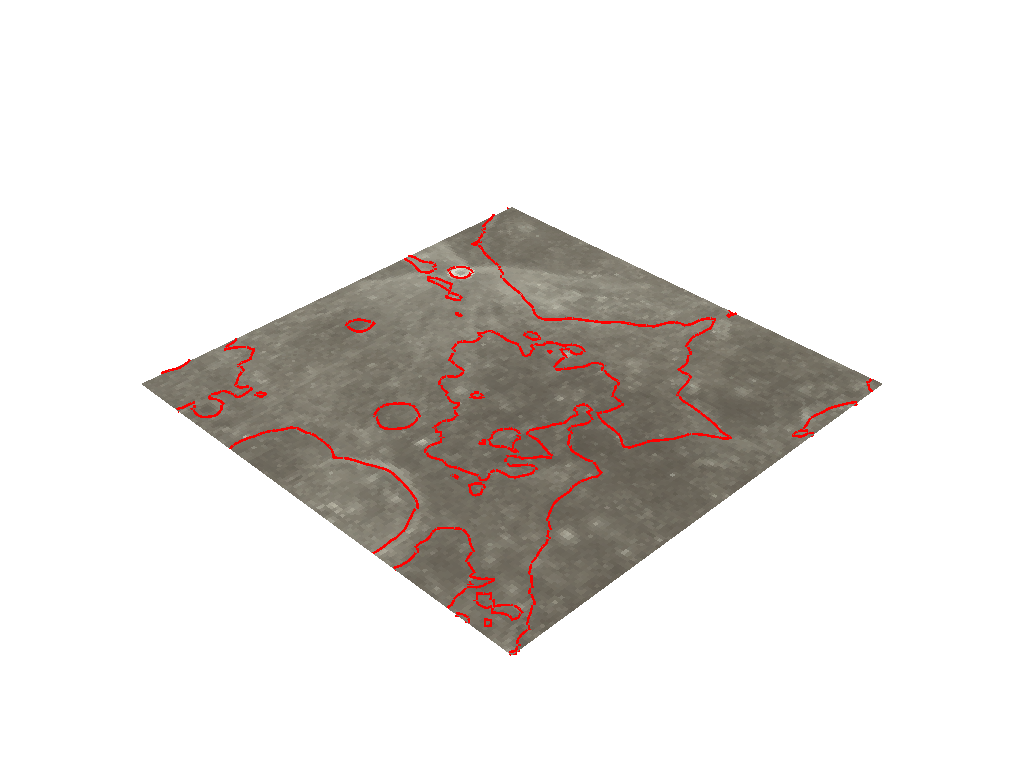

In [27]:
builtin_subset_16 = subset_16.warp_by_scalar()
subset_16_contours = builtin_subset_16.contour(isosurfaces = [0])

#Add texture coordinates
subset_16.texture_map_to_plane(inplace = True)

plotter = pv.Plotter()
plotter.add_mesh(subset_16, texture = lunar_color_subset)
plotter.add_mesh(subset_16_contours, color="red", line_width=5)
plotter.show()

Running the following cell will spawn an external viewer that contains an interactive 3-D view of the above plot. 
It is commented out because it can cause performance issues. Uncomment to launch the external viewer, and use your 
mouse and control/command buttons to navigate and explore the lunar color image. You may need to force quit it if it ends up using too many resources or if it interferes with running additional cells in this notebook.

In [28]:
'''
plotter = pvqt.BackgroundPlotter()
plotter.add_mesh(subset_16, texture = lunar_color_subset)
plotter.add_mesh(subset_16_contours, color="red", line_width=5)
'''

'\nplotter = pvqt.BackgroundPlotter()\nplotter.add_mesh(subset_16, texture = lunar_color_subset)\nplotter.add_mesh(subset_16_contours, color="red", line_width=5)\n'

If you inspect the interactive views of these contour plots, you'll clearly notice that the Dual Marching Squares provides much smoother contours. It is much better suited to the lunar terrain than the built-in PyVista Primal method.

## Conclusion and Next Steps

As we have seen, generating contours using Dual Marching Squares gives us smoother isolines. This is an advantage when visualizing lunar terrain, where there are many circular craters.

The next steps for this project would include:

- Allowing the user to toggle between Primal and Dual Contours while viewing the lunar terrain
- Addressing any performance issues, to be able to see more of the lunar terrain in a single contoured plot
- Mapping the lunar color image and the contours to a sphere, which could then be interactively viewed
